<a href="https://colab.research.google.com/github/kangeunsong/2025-1_CV/blob/main/Assignment/HW%232.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW#2

### HW2-1: Gamma 보정 실험

Fig3.9(a)의 aerial image에 대해 다양한 감마 값(3.0, 4.0, 5.0)을 적용하여 밝기 보정 효과를 관찰한다.  
감마 보정은 이미지의 픽셀 값을 비선형적으로 조정함으로써 전체 밝기 분포를 조절하는 데 효과적이다.

**감마 값이 커질수록 어두운 픽셀들이 더 억제되어 전체 이미지가 더 어두워진다.**

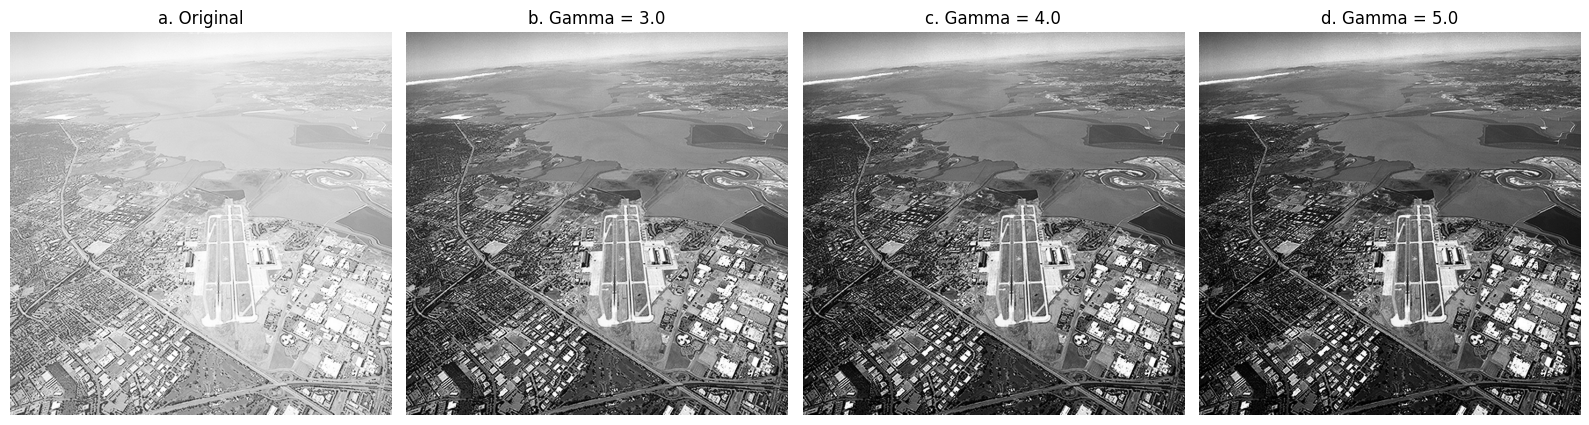

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img_path = '/content/Fig0309(a)(washed_out_aerial_image).tif'
img = cv.imread(img_path, cv.IMREAD_UNCHANGED)

# 이미지가 컬러라면 RGB로 변환
if len(img.shape) == 2:
    is_gray = True
else:
    is_gray = False
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# 감마 보정 함수
def gamma_transform(image, gamma=1.0):
    norm_img = image / 255.0
    gamma_corrected = np.power(norm_img, gamma)
    return np.uint8(gamma_corrected * 255)

# 다양한 감마 값 적용
gamma_3 = gamma_transform(img, 3.0)
gamma_4 = gamma_transform(img, 4.0)
gamma_5 = gamma_transform(img, 5.0)

# 결과 시각화
titles = ['a. Original', 'b. Gamma = 3.0', 'c. Gamma = 4.0', 'd. Gamma = 5.0']
images = [img, gamma_3, gamma_4, gamma_5]

plt.figure(figsize=(16, 8))
for i in range(4):
    plt.subplot(1, 4, i+1)
    if is_gray:
        plt.imshow(images[i], cmap='gray')
    else:
        plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

### HW2-2: 명암 대비 조절을 위한 선형 구간 변환

명암 대비가 낮은 Fig.3.10(b)의 pollen 이미지에 대해 구간별 선형 변환을 적용하여 특정 밝기 영역의 대비를 향상시켰다.  
변환 함수는 **세 개의 구간**으로 나뉘어 각기 다른 비율로 밝기를 조절하며, 이후 **thresholding**을 통해 이진화 효과를 확인하였다.

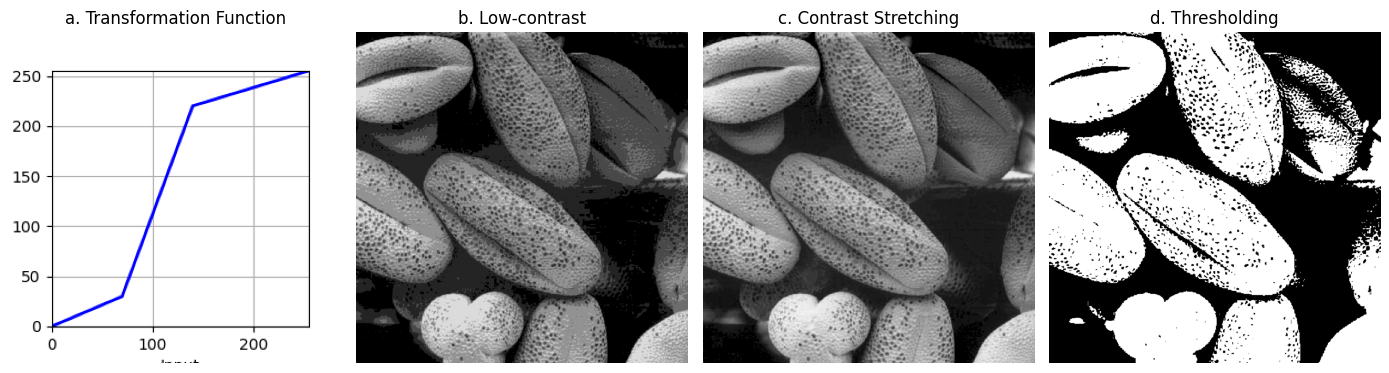

In [27]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

img_path = '/content/Fig0310(b)(washed_out_pollen_image).tif'
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

# 대비 낮추는 함수 (b)
def low_contrast(image, alpha=0.15, beta=100):
    return cv.convertScaleAbs(image, alpha=alpha, beta=beta)

# 구간별 선형 stretching 함수 (c)
def contrast_stretch(image):
    in_min, in_max = 70, 140
    out_min, out_max = 30, 220

    result = np.zeros_like(image, dtype=np.uint8)

    # 구간 1: 저밝기 → 저출력
    mask1 = image < in_min
    result[mask1] = (image[mask1] / in_min * out_min).astype(np.uint8)

    # 구간 2: 중간 밝기 → 강하게 늘리기
    mask2 = (image >= in_min) & (image <= in_max)
    result[mask2] = ((image[mask2] - in_min) / (in_max - in_min) * (out_max - out_min) + out_min).astype(np.uint8)

    # 구간 3: 고밝기 → 상한선 제한
    mask3 = image > in_max
    result[mask3] = ((image[mask3] - in_max) / (255 - in_max) * (255 - out_max) + out_max).astype(np.uint8)

    return result

# 변환 함수 시각화 (a)
def generate_piecewise_plot():
    x = np.array([0, 70, 140, 255])
    y = np.array([0, 30, 220, 255])

    fig = Figure(figsize=(3, 3))
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    ax.plot(x, y, 'b', linewidth=2)
    ax.set_xlabel('Input')
    ax.set_ylabel('Output')
    ax.grid(True)
    ax.set_xlim(0, 255)
    ax.set_ylim(0, 255)
    canvas.draw()

    buf = canvas.buffer_rgba()
    plot_img = np.asarray(buf)
    return plot_img

a_img = generate_piecewise_plot()
b_img = low_contrast(img)
c_img = contrast_stretch(img)
_, d_img = cv.threshold(c_img, 128, 255, cv.THRESH_BINARY) # thresholding 적용 (d)

fig, axes = plt.subplots(1, 4, figsize=(14, 4))

# 결과 시각화
titles = ['a. Transformation Function', 'b. Low-contrast', 'c. Contrast Stretching', 'd. Thresholding']
images = [a_img, b_img, c_img, d_img]

for ax, im, title in zip(axes, images, titles):
    if len(im.shape) == 2:
        ax.imshow(im, cmap='gray')
    else:
        ax.imshow(im)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

### HW2-3: 다양한 마스크에 의한 영상 필터링 결과 비교

임의의 이미지를 대상으로 평균 필터, 가우시안 필터, 샤프닝, 라플라시안, 소벨 X/Y 등의 마스크를 적용하여 그 차이를 비교하였다.

비교의 핵심 포인트는 **경계가 얼마나 날카롭게 표현되는가**, 혹은 **영상이 얼마나 부드럽게 되는가**이다.

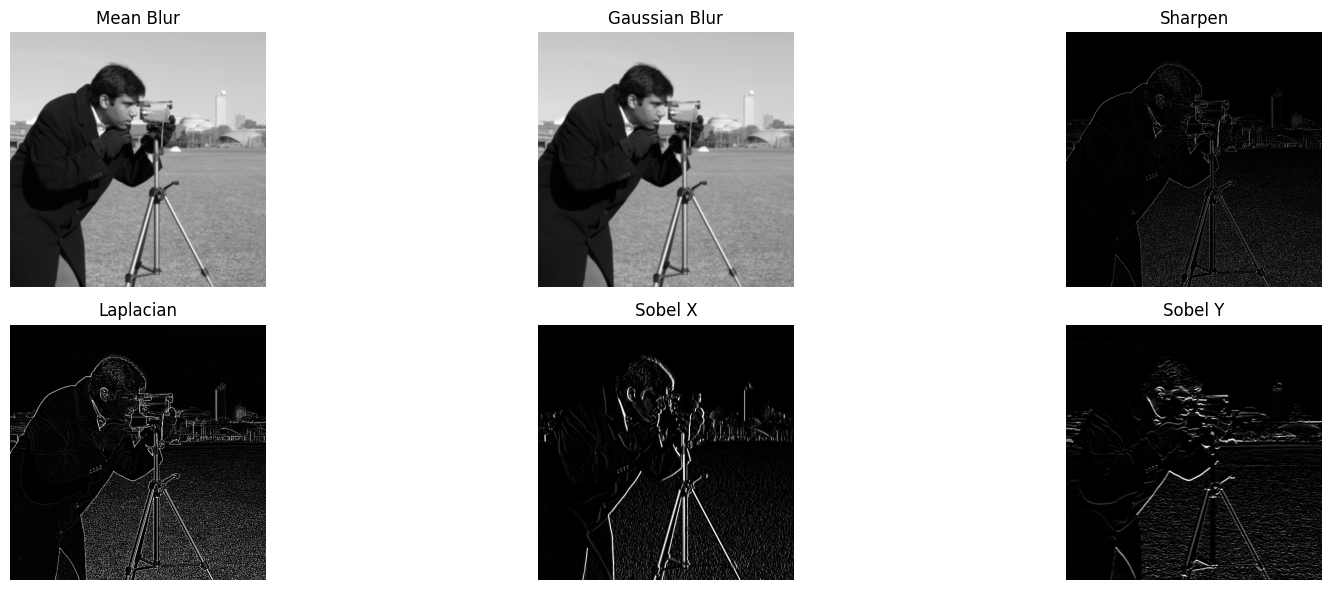

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 로드 (흑백)
img = cv2.imread('/content/cameraman.png', cv2.IMREAD_GRAYSCALE)

# 필터 정의
mean_filter = np.ones((3, 3), np.float32) / 9 # 평균 필터 (블러 효과)
gaussian_filter = np.array([
    [0.0030, 0.0133, 0.0219, 0.0133, 0.0030],
    [0.0133, 0.0596, 0.0983, 0.0596, 0.0133],
    [0.0219, 0.0983, 0.1621, 0.0983, 0.0219],
    [0.0133, 0.0596, 0.0983, 0.0596, 0.0133],
    [0.0030, 0.0133, 0.0219, 0.0133, 0.0030]
]) # 가우시안 필터
sharpen = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) # 샤프닝 (경계 강조)
laplacian = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]) # 라플라시안 (에지 강조)
sobel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]) # 수직 에지
sobel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]) # 수평 에지

filters = [mean_filter, gaussian_filter, sharpen, laplacian, sobel_x, sobel_y]
titles = ['Mean Blur', 'Gaussian Blur', 'Sharpen', 'Laplacian', 'Sobel X', 'Sobel Y']

# 필터 적용 결과 출력
plt.figure(figsize=(18, 6))
for i, (filt, title) in enumerate(zip(filters, titles)):
    result = cv2.filter2D(img, -1, filt)
    plt.subplot(2, 3, i+1)
    plt.imshow(result, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

### HW2-4: 변형된 Sobel 필터로 45°, -45° 대각선 에지 검출

Sobel 연산자를 수직·수평이 아닌 대각선 방향(45°, -45°)에 맞게 변형하여 학교 이미지의 경계를 검출하였다.

기존의 Sobel X/Y와 달리, 대각선 방향의 경계가 강조되는 것을 확인할 수 있다.  
경계가 흐릿하거나 누락된 부분 없이 **대각선 방향 물체 윤곽을 잘 살리는가**에 초점을 두었다.

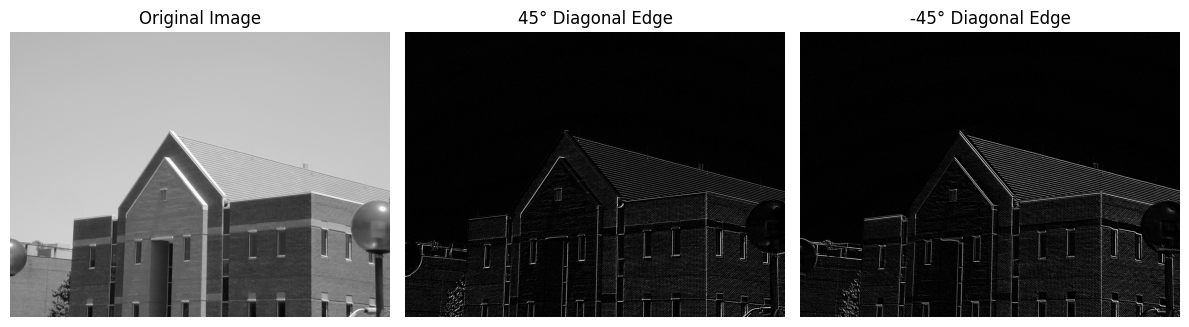

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('/content/school.jpg', cv2.IMREAD_GRAYSCALE)

# 45°, -45° Sobel 필터 정의
# 기존 Sobel에서 대각선 방향으로 변형
sobel_45 = np.array([
    [-1, -2,  0],
    [-2,  0,  2],
    [ 0,  2,  1]
], dtype=np.float32)

sobel_m45 = np.array([
    [ 0,  2,  1],
    [-2,  0,  2],
    [-1, -2,  0]
], dtype=np.float32)

# filter2D로 직접 컨볼루션 적용
edge_45 = cv2.filter2D(img, -1, sobel_45)
edge_m45 = cv2.filter2D(img, -1, sobel_m45)

# 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edge_45, cmap='gray')
plt.title('45° Diagonal Edge')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edge_m45, cmap='gray')
plt.title('-45° Diagonal Edge')
plt.axis('off')

plt.tight_layout()
plt.show()

### HW2-5: 지문 영상 노이즈 제거 (Opening + Closing)

지문 영상에 대해 Opening과 Closing을 연속적으로 적용하여 배경 노이즈를 제거하고 선명한 윤곽을 복원하였다.

Otsu 이진화를 기반으로 처리하며, 모폴로지 연산을 통해 **불필요한 잡음을 제거**하면서 **지문 구조는 유지**했다.

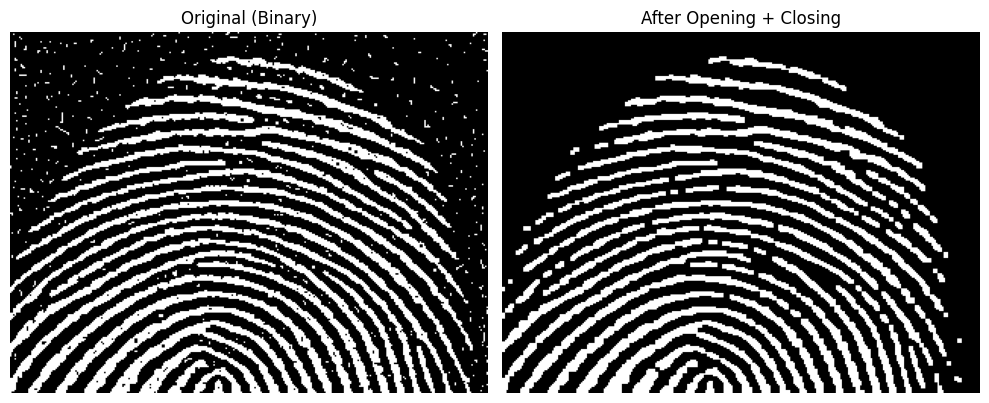

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('/content/finger.jpg', cv2.IMREAD_GRAYSCALE)

# 이진화 (Otsu's method)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 구조 요소 및 연산 정의
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Opening → 작은 잡음 제거
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
# Closing → 끊긴 지문 선 연결
opened_closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

# 결과 시각화
titles = ['Original (Binary)', 'After Opening + Closing']
images = [binary, opened_closed]

plt.figure(figsize=(10, 4))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### HW2-6: 다양한 크기의 구조 요소를 사용한 침식 연산

wirebond 마스크 이미지에 대해 11×11, 15×15, 45×45 구조 요소로 침식(Erosion)을 수행하였다.

구조 요소가 클수록 더 많은 정보가 사라지며, 결국 중앙 부분을 제외한 모든 객체가 완전히 제거된다.  
비교 포인트는 **구조 요소 크기에 따라 제거되는 객체의 크기 차이와 배경의 변화**이다.

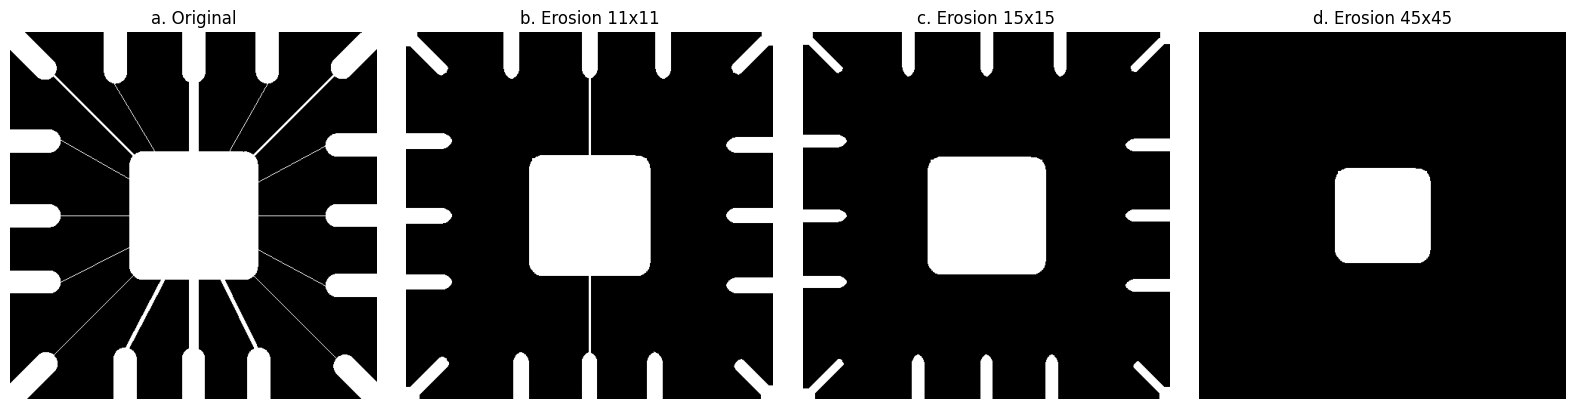

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('/content/Fig0905(a)(wirebond-mask).tif', cv2.IMREAD_GRAYSCALE)

# 이진화 (혹시 대비 부족할 경우를 대비)
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# 다양한 크기의 구조 요소 정의 (크기가 클수록 더 많이 깎임)
se_11 = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
se_15 = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
se_45 = cv2.getStructuringElement(cv2.MORPH_RECT, (45, 45))

# 침식(Erosion) 연산 적용
eroded_11 = cv2.erode(binary, se_11)
eroded_15 = cv2.erode(binary, se_15)
eroded_45 = cv2.erode(binary, se_45)

# 결과 시각화
titles = ['a. Original', 'b. Erosion 11x11', 'c. Erosion 15x15', 'd. Erosion 45x45']
images = [binary, eroded_11, eroded_15, eroded_45]

plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### HW2-7: CT 이미지에 대한 여러 에지 검출 기법 비교

Morphological Gradient, Dilation, Erosion 등을 조합하여 경계를 시각화하였다.  
특히 **Morphological Gradient**는 경계를 뚜렷하게 표현하는 데 적합하며, 내부 텍스처가 강조되지 않아 **윤곽만 추출할 수 있다**는 장점이 있다.

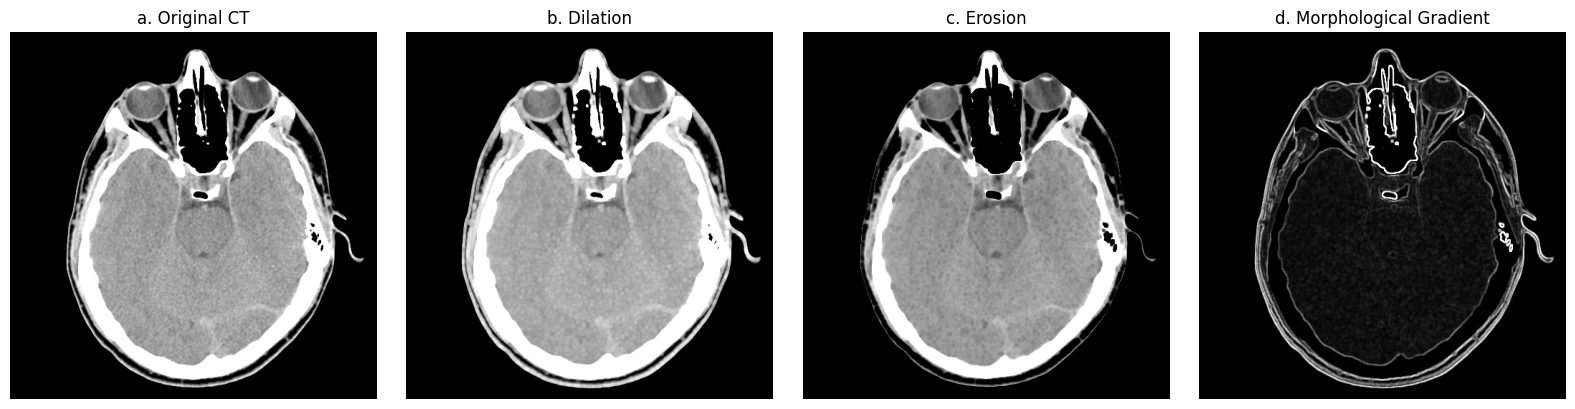

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('/content/Fig0939(a)(headCT-Vandy).tif', cv2.IMREAD_GRAYSCALE)

# 구조 요소 정의 (3x3 사각형)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# 팽창, 침식 연산
dilated = cv2.dilate(img, kernel)
eroded = cv2.erode(img, kernel)
# 형태학적 기울기: 경계 강조 (gradient = dilation - erosion)
gradient = cv2.subtract(dilated, eroded)

# 결과 시각화
titles = ['a. Original CT', 'b. Dilation', 'c. Erosion', 'd. Morphological Gradient']
images = [img, dilated, eroded, gradient]

plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# dilation은 밝은 영역 확장
# erosion은 어두운 영역 확장
# → gradient는 밝기 경계선만 남아 경계 강조 효과

### HW2-8: Morphological Smoothing vs. Smoothing Filter 비교

cygnusloop X-ray 이미지에 대해 Morphological 연산과 일반 필터링을 적용해 노이즈 제거 성능을 비교하였다.

Morphological 방식은 구조적 노이즈에 강하고, Smoothing 필터는 전체적으로 부드러운 결과를 제공했다.  
**경계 유지 정도와 세부 구조 손실 여부**를 중점으로 보았다.

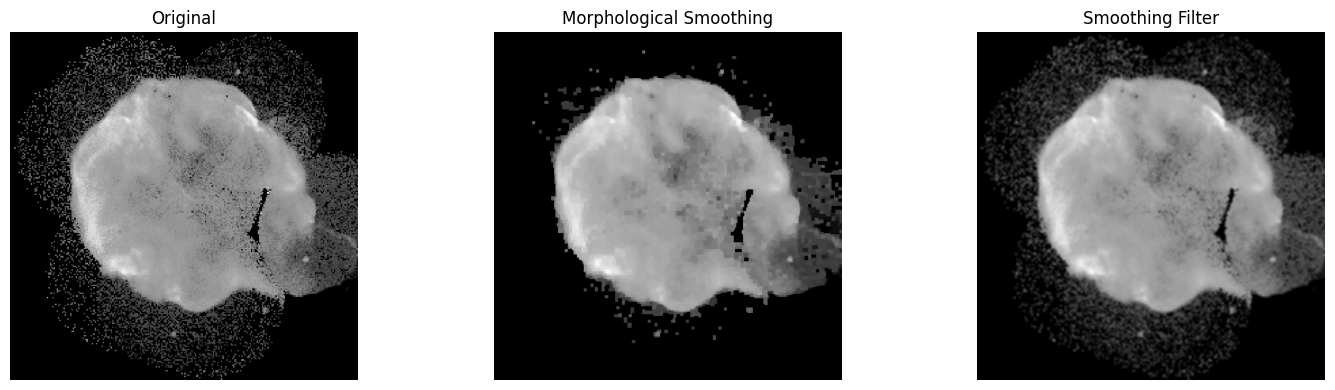

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('/content/Fig0938(a)(cygnusloop_Xray_original).tif', cv2.IMREAD_GRAYSCALE)

# 모폴로지 연산 (Opening -> Closing)
kernel_morph = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
morph_open = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_morph)
morph_smooth = cv2.morphologyEx(morph_open, cv2.MORPH_CLOSE, kernel_morph)

# 일반 Smoothing filter (mean blur)
smooth_blur = cv2.blur(img, (5, 5))

# 결과 시각화
titles = ['Original', 'Morphological Smoothing', 'Smoothing Filter']
images = [img, morph_smooth, smooth_blur]

plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### HW2-9: 밝기 기울기 보정 후 이진화

배경 밝기 기울기가 존재하는 쌀알 영상에 대해 Otsu만 적용한 경우와, Top-hat으로 전처리 후 Otsu를 적용한 경우를 비교하였다.

Top-hat은 밝은 객체(쌀)를 강조하고, Otsu는 이진화 성능을 높인다.   
**Top-hat을 함께 사용**했을 때 **쌀알이 더 깔끔하게 추출**된 것을 볼 수 있다.

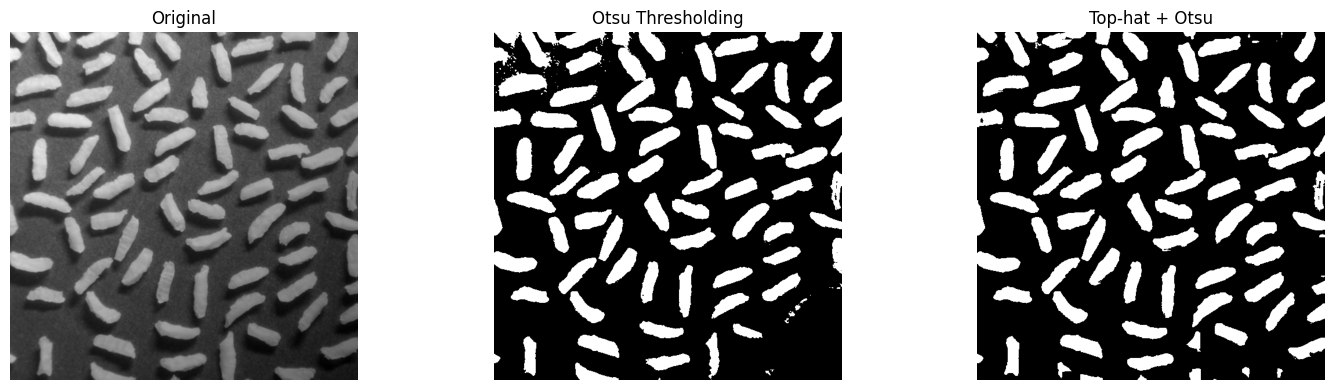

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('/content/Fig0940(a)(rice_image_with_intensity_gradient).tif', cv2.IMREAD_GRAYSCALE)

# Top-hat 변환: 밝은 객체 강조, 배경 밝기 보정
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)

# Otsu 이진화: 전역 임계값 자동 계산
_, otsu_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, tophat_otsu_bin = cv2.threshold(tophat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 결과 시각화
titles = ['Original', 'Otsu Thresholding', 'Top-hat + Otsu']
images = [img, otsu_bin, tophat_otsu_bin]

plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Otsu만 적용 시 밝기 기울기 때문에 일부 쌀알 인식 실패
# Top-hat 선처리 후 Otsu 적용 시 훨씬 선명하게 인식 가능

### HW2-10: 형태학적 연산을 활용한 블롭 분할

dark blobs 이미지에 대해 Closing → Opening → Morphological Gradient 연산을 수행하여  
작은 얼룩 제거, 밝은 패치 제거, 그리고 경계선 추출까지 일련의 분할 과정을 시각화하였다.

최종 결과에서는 얇은 흰색 경계선이 객체 간 경계를 정확하게 강조하며, **중요 객체는 유지하면서 불필요한 정보는 제거된 모습**을 확인할 수 있다.

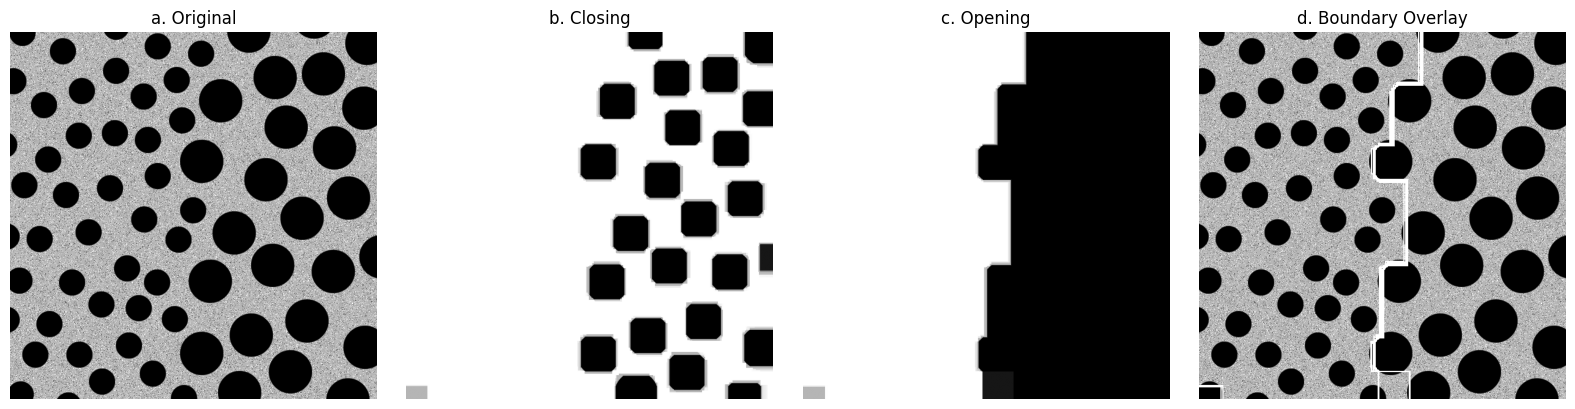

In [60]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img = cv.imread('/content/Fig0943(a)(dark_blobs_on_light_background).tif', cv.IMREAD_GRAYSCALE)

# 닫힘 연산: 작은 블롭 제거 (구조 요소 크기는 얼룩보다 큼)
kernel_close = cv.getStructuringElement(cv.MORPH_RECT, (42, 42))
closed = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel_close)

# 열림 연산: 밝은 패치 제거 (구조 요소는 블롭 간 간격보다 큼)
kernel_open = cv.getStructuringElement(cv.MORPH_RECT, (90, 90))
opened = cv.morphologyEx(closed, cv.MORPH_OPEN, kernel_open)

# 형태학적 기울기: 경계선 추출
kernel_grad = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
gradient = cv.morphologyEx(opened, cv.MORPH_GRADIENT, kernel_grad)

# 경계선 부분을 흰색(255)으로 덧씌움
result = img.copy()
result[gradient > 0] = 255  # 흰색 선 표시

# 결과 시각화
titles = ['a. Original', 'b. Closing', 'c. Opening', 'd. Boundary Overlay']
images = [img, closed, opened, result]

plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()